In [1]:
%matplotlib notebook
import orbipy as op
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from copy import copy
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d

In [2]:
model = op.crtbp3_model()
precise_model = op.crtbp3_model()
precise_model.integrator.set_params(max_step=np.pi/180)
stm_model = op.crtbp3_model(stm=True)

In [3]:
plotter = op.plotter.from_model(model, length_units='nd', velocity_units='nd/nd')
scaler = plotter.scaler

In [4]:
class Hyperbolic:
    def __init__(self):
        self.c2 = self.calc_c2()
        self.lam = self.calc_lam()
        self.omega = self.calc_omega()
        self.k1 = self.calc_k1()
        self.k2 = self.calc_k2()
        self.k3 = self.calc_k3()
        self.k4 = self.calc_k4()
        
    def p1(self, state):
        (x, y) = state[:2]
        x -= model.L1
        (vx, vy) = state[3:5]
        
        return ((self.k3*self.omega*x-self.k1*vy)/(self.k1*self.k4*self.lam+self.k2*self.k3*self.omega) +\
                (self.k1*self.omega*y+self.k3*vx)/(self.k2*self.k3*self.lam-self.k1*self.k4*self.omega))/2
    
    def p1_table(self, orbit):
        x = orbit['x'].values - model.L1
        vx = orbit['vx'].values
        y = orbit['y'].values
        vy = orbit['vy'].values
        
        return ((self.k3*self.omega*x-self.k1*vy)/(self.k1*self.k4*self.lam+self.k2*self.k3*self.omega) +\
                (self.k1*self.omega*y+self.k3*vx)/(self.k2*self.k3*self.lam-self.k1*self.k4*self.omega))/2
    
    def p2_table(self, orbit):
        x = orbit['x'].values - model.L1
        vx = orbit['vx'].values
        y = orbit['y'].values
        vy = orbit['vy'].values
        
        return ((self.k3*self.omega*x-self.k1*vy)/(self.k1*self.k4*self.lam+self.k2*self.k3*self.omega) -\
                (self.k1*self.omega*y+self.k3*vx)/(self.k2*self.k3*self.lam-self.k1*self.k4*self.omega))/2
    
    def p2(self, state):
        (x, y) = state[:2]
        x -= model.L1
        (vx, vy) = state[3:5]
        
        return ((self.k3*self.omega*x-self.k1*vy)/(self.k1*self.k4*self.lam+self.k2*self.k3*self.omega) -\
                (self.k1*self.omega*y+self.k3*vx)/(self.k2*self.k3*self.lam-self.k1*self.k4*self.omega))/2
    
    def calc_vy(self, state):
        (x, y) = state[:2]
        x -= model.L1
        (vx, vy) = state[3:5]
        
        return (self.k3*self.omega*x+(self.k1*self.k4*self.lam+self.k2*self.k3*self.omega)*(self.k1*self.omega*y+self.k3*vx)/(self.k2*self.k3*self.lam-self.k1*self.k4*self.omega))/self.k1
        
    def calc_c2(self):
        r1 = np.abs(model.L1+model.mu)
        r2 = np.abs(model.L1+model.mu-1)
        
        return (1.-model.mu)/r1**3+model.mu/r2**3
    
    def calc_lam(self):
        return np.sqrt((self.c2-2+np.sqrt(9*self.c2**2-8*self.c2))/2)
    
    def calc_omega(self):
        return np.sqrt((-1.*self.c2+2+np.sqrt(9*self.c2**2-8*self.c2))/2)
        
    def calc_k1(self):
        return -2/(self.c2+3+self.lam**2)
    
    def calc_k2(self):
        return -2/(2*self.c2+1-self.lam**2)
    
    def calc_k3(self):
        return (self.omega*(self.c2-1+self.lam**2))/((self.c2-1)*(self.c2+3+self.lam**2))
    
    def calc_k4(self):
        return (self.lam*(-2*self.c2+3+self.lam**2))/((self.c2-1)*(-2*self.c2-1+self.lam**2))

In [5]:
hyp = Hyperbolic()

In [6]:
def interactive_map(data, buffer):
    def onclick(event):
        if event.button == 3:
            ix, iy = event.xdata, event.ydata
            buffer.append([ix, iy])
            ax.plot(ix, iy, 'or')
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(data['x0'], data['z0'], 'ob')
    ax.axis('equal')
    cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [7]:
with open('amp.pkl', 'rb') as fp:
    applicability = pickle.load(fp)

# Запустите ячейку и выберите начальную точку левой кнопкой мыши, выключите график

<IPython.core.display.Javascript object>


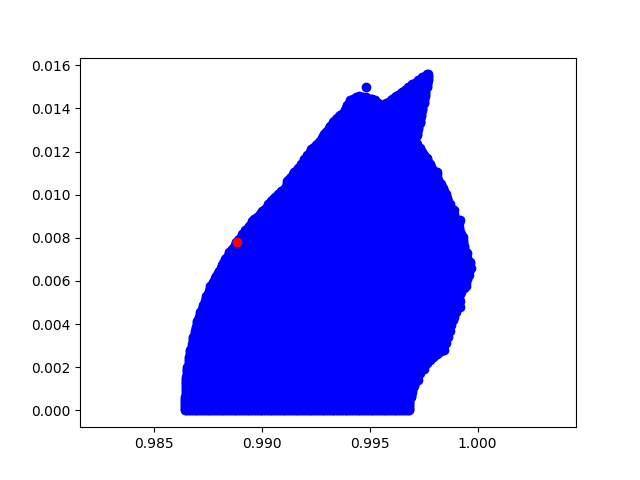

In [8]:
buffer = []
interactive_map(applicability, buffer)

In [9]:
x0 = buffer[-1][0]
z0 = buffer[-1][1]
dx = scaler(-1000, 'km-nd')

In [10]:
EL1_dist = 1.-model.mu - model.L1
left = op.eventX(model.L1-EL1_dist)
right = op.eventX(1.-model.mu)

first_corr = op.border_correction(model, op.y_direction(), [left], [right])
corr = op.border_correction(model, op.y_direction(), [left], [right])
sk = op.simple_station_keeping(precise_model, first_corr, corr, rev=np.pi/2)

In [11]:
s0 = model.get_zero_state()
s0[0] = x0
s0[2] = z0

In [12]:
orb1 = sk.prop(0.0, s0, N=30)

Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 


In [13]:
left_points = pd.DataFrame(np.array([[left.value, y, 0,0,0,0] for y in np.linspace(-0.020,0.020,20)]), columns=orb1.columns.values[1:])
right_points = pd.DataFrame(np.array([[right.value, y, 0,0,0,0] for y in np.linspace(-0.020,0.020,20)]), columns=orb1.columns.values[1:])

<IPython.core.display.Javascript object>


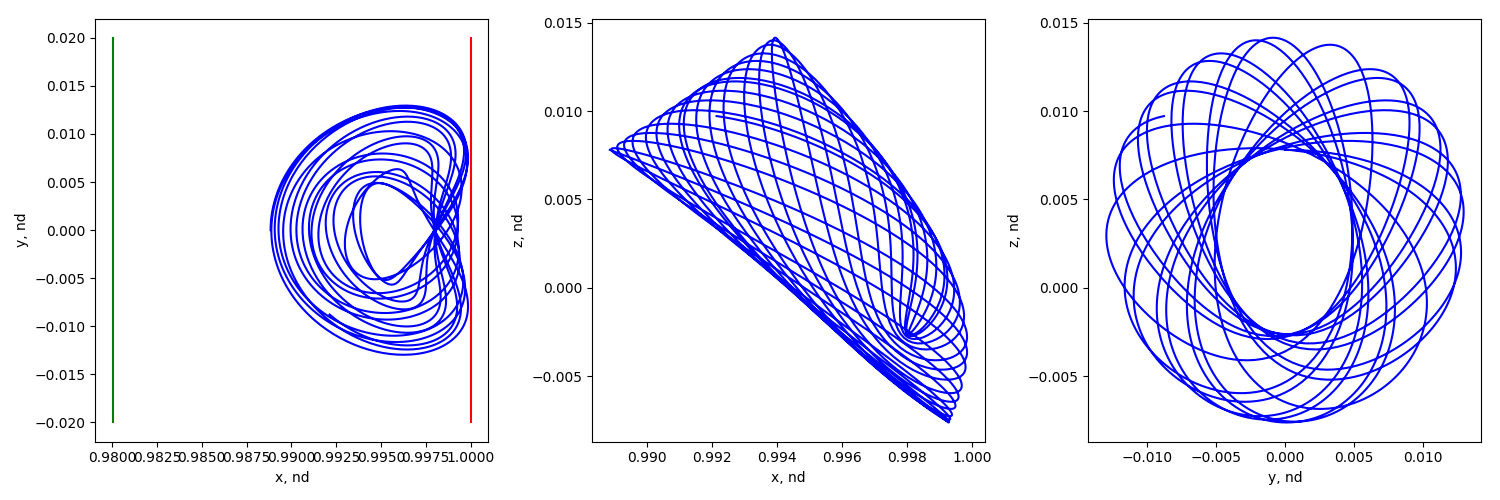

In [14]:
ax = plotter.plot_proj(orb1)
ax[0].plot(left_points['x'], left_points['y'],'g')
ax[0].plot(right_points['x'], right_points['y'],'r')

In [15]:
orb1_hyp = pd.DataFrame()
left_points_hyp = pd.DataFrame()
right_points_hyp = pd.DataFrame()
orb1_hyp['p1'] = hyp.p1_table(orb1)
orb1_hyp['p2'] = hyp.p2_table(orb1)

earth_p1 = hyp.p1(np.array([model.mu1,0,0,0,0,0]))
earth_p2 = hyp.p2(np.array([model.mu1,0,0,0,0,0]))

left_points_hyp['p1'] = hyp.p1_table(left_points)
left_points_hyp['p2'] = hyp.p2_table(left_points)

right_points_hyp['p1'] = hyp.p1_table(right_points)
right_points_hyp['p2'] = hyp.p2_table(right_points)

<IPython.core.display.Javascript object>


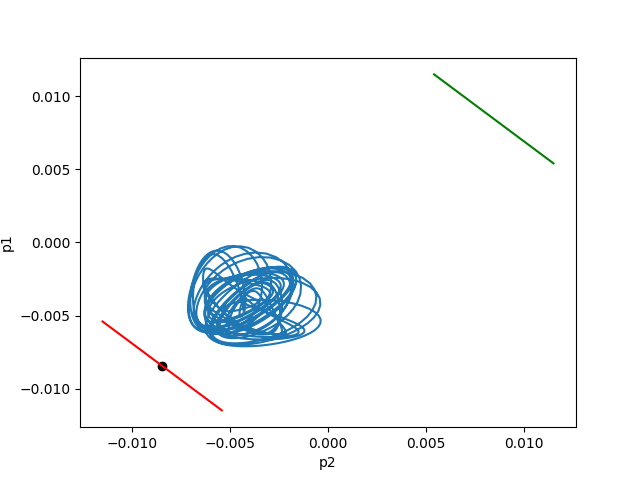

Text(0, 0.5, 'p1')

In [16]:
plt.plot(orb1_hyp['p2'], orb1_hyp['p1'])
plt.plot(earth_p2, earth_p1,'ko')
plt.plot(left_points_hyp['p2'], left_points_hyp['p1'], 'g')
plt.plot(right_points_hyp['p2'], right_points_hyp['p1'], 'r')
plt.xlabel('p2')
plt.ylabel('p1')

In [17]:
class EventP1(op.base_event):
    def __call__(self, t, s):
        return hyp.p1(s) - self.value

In [18]:
def final_pos(s0, v_range, events):
    es = []
    traj = []
    det = op.event_detector(model, events)
    for v in v_range:
        s1 = s0.copy()
        s1[4] = v
        df, ev = det.prop(s1, 0.0, 10*np.pi)
        ev_happened = ev.iloc[0]['e']
        if len(es)>1:
            if ev_happened != es[-1]:
                traj.append(df)
        es.append(ev_happened)
    plt.plot(v_range, es)
    plt.axvline(s0[4],c='r')
    return traj

In [19]:
p1_left = EventP1(value=-0.0078, terminal=True)
p1_right = EventP1(value=0.00078, terminal=True)

<IPython.core.display.Javascript object>


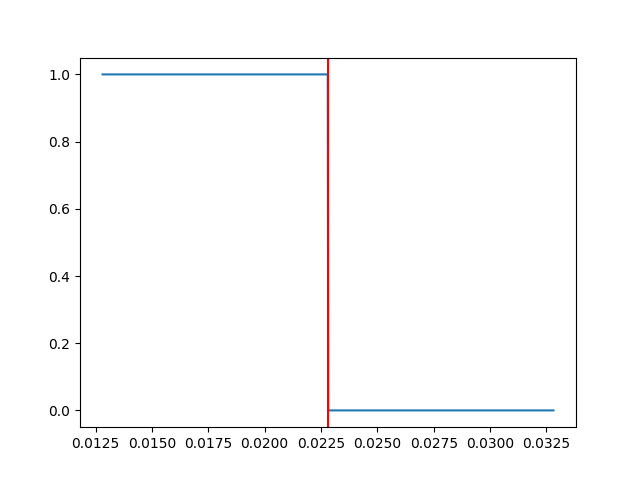

In [21]:
s1 = orb1.iloc[0].values[1:]
dv = 0.01
tr = final_pos(s1, np.linspace(s1[4]-dv,s1[4]+dv,1000), [p1_left, p1_right])

In [22]:
first_corr_p = op.border_correction(model, op.y_direction(), [p1_left], [p1_right])
corr_p = op.border_correction(model, op.y_direction(), [p1_left], [p1_right])
sk_p = op.simple_station_keeping(precise_model, first_corr, corr, rev=np.pi/2)

In [23]:
s2 = model.get_zero_state()
s2[0] = s1[0]
s2[2] = s1[2]
df = sk_p.prop(0.0, s2, 30)

Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 


<IPython.core.display.Javascript object>


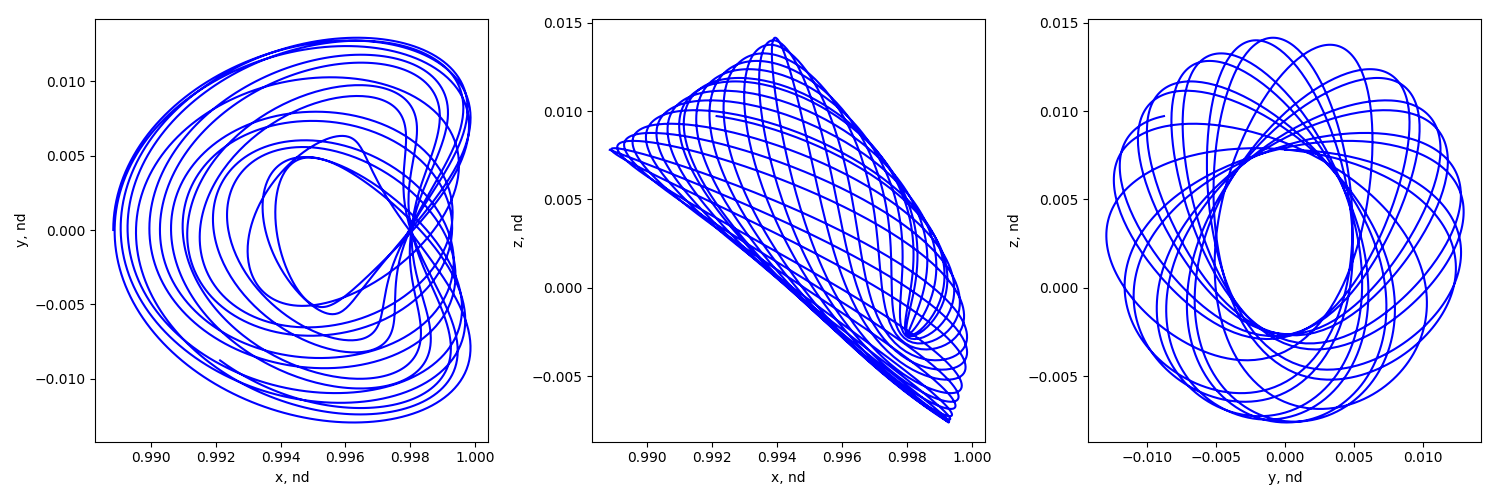

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f19fd6e62b0>,
      dtype=object)

In [24]:
plotter.plot_proj(df)

In [25]:
large_orbs = pickle.load(open('../large_orbs_examples.bin','rb'))

In [26]:
orb2 = large_orbs[100]

<IPython.core.display.Javascript object>


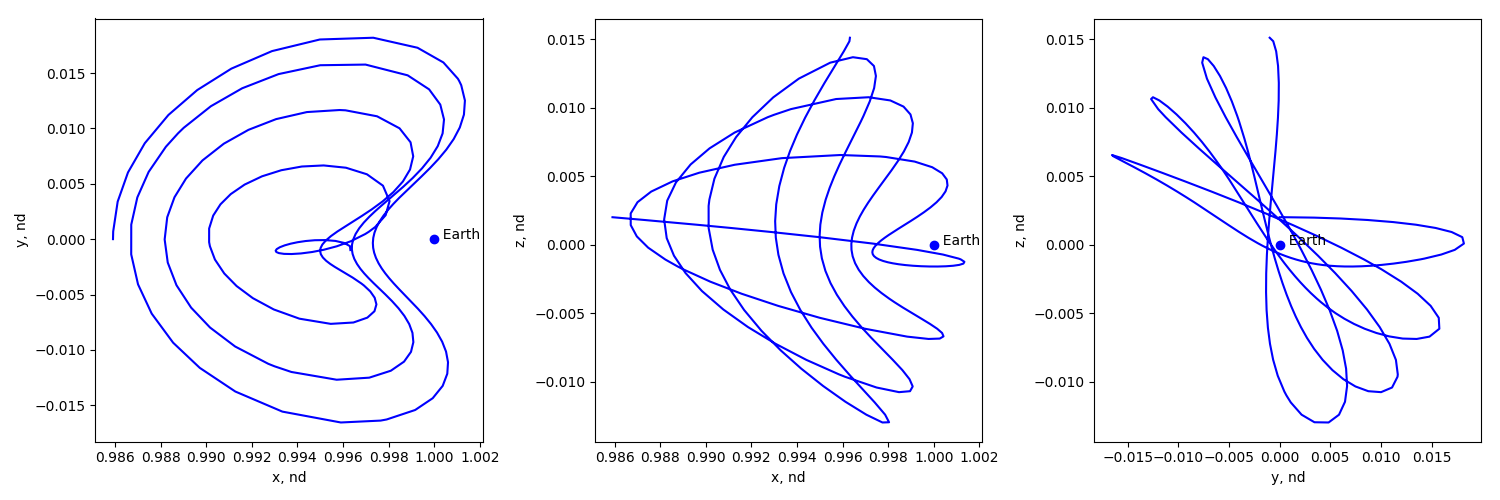

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f19fd2cff60>,
      dtype=object)

In [27]:
ax = plotter.plot_proj(orb2)
plotter.plot_proj(ax=ax, plottables=[plotter.m], marker='o')

In [28]:
orb2_hyp = pd.DataFrame()
orb2_hyp['p1'] = hyp.p1_table(orb2)
orb2_hyp['p2'] = hyp.p2_table(orb2)

<IPython.core.display.Javascript object>


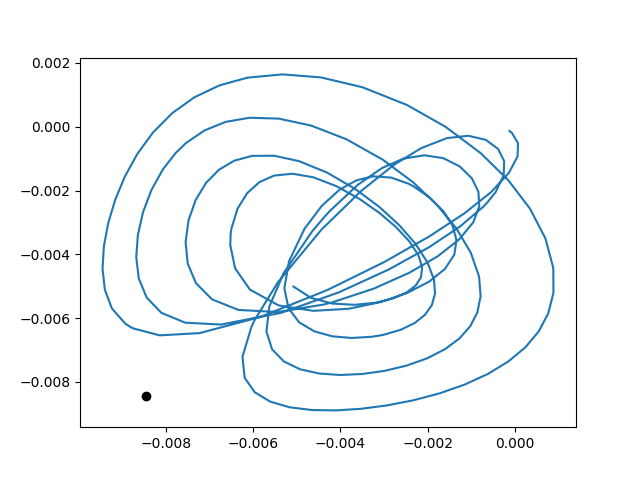

In [29]:
plt.plot(orb2_hyp['p2'], orb2_hyp['p1'])
plt.plot(earth_p2, earth_p1,'ko')

In [48]:
p1_left = EventP1(value=-0.01, terminal=True)
p1_right = EventP1(value=0.003, terminal=True)

<IPython.core.display.Javascript object>


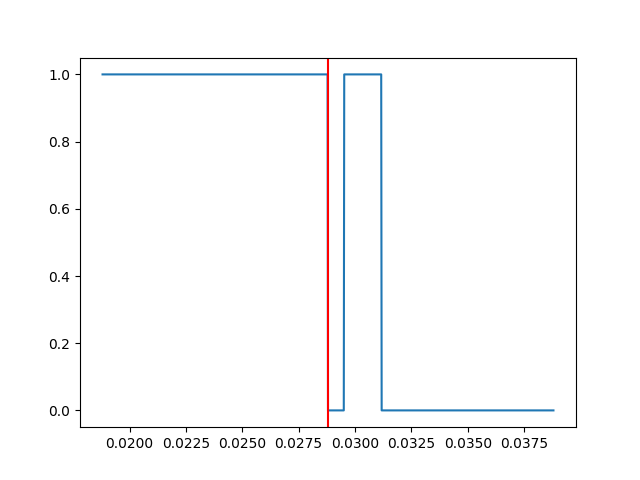

In [49]:
s1 = orb2.iloc[0].values[1:]
dv = 0.01
tr = final_pos(s1, np.linspace(s1[4]-dv,s1[4]+dv,1001), [p1_left, p1_right])

<IPython.core.display.Javascript object>


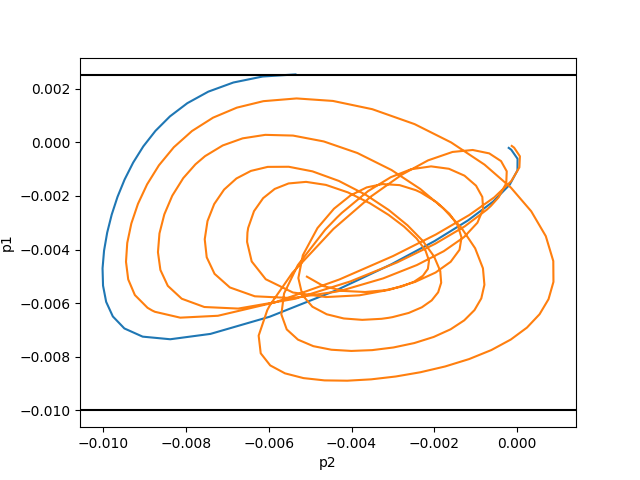

Text(0, 0.5, 'p1')

In [47]:
data = tr[1]
tr_hyp = pd.DataFrame()
tr_hyp['p1'] = hyp.p1_table(data)
tr_hyp['p2'] = hyp.p2_table(data)
plt.plot(tr_hyp['p2'], tr_hyp['p1'])
plt.plot(orb2_hyp['p2'], orb2_hyp['p1'])
plt.axhline(p1_left.value, color='k')
plt.axhline(p1_right.value, color='k')
plt.xlabel('p2')
plt.ylabel('p1')
# plotter.plot_proj(tr[2])